<a href="https://colab.research.google.com/github/avanc13/CS506Project/blob/main/average_delay_improved_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***MBTA Bus Delay & Rider Wait Time Prediction***
This notebook analyzes MBTA bus arrival and departure data from 2018–2025 to understand system-wide performance and build predictive models of bus delay and passenger wait time.

The workflow in this notebook performs the following major steps:

**Extract raw MBTA data:**
Unzips the annual datasets into a working directory for processing.

**Standardize and clean the CSV files:**
Because each year uses slightly different column names and formats, all files are normalized into a consistent schema (e.g., route_id, scheduled, actual, scheduled_headway, headway, etc.).

**Engineer key operational metrics:**

- Delay (minutes): difference between actual and scheduled arrival time

- Headway (minutes): spacing between buses along a route

- Passenger wait time: derived from headway and on-time performance

- Status label: “On-time” vs. “Delayed” based on MBTA standards

**Aggregate performance for target routes:**
Focuses on a predefined set of MBTA routes with historically high ridership and variability in performance.

**Modeling goals:**
This project builds machine learning models to predict bus delay and passenger wait time using engineered features such as:

- route, year, month, day of week

- scheduled vs. actual time

- time of day

- headway deviation

- historical delay patterns

The primary predictive objectives are:

- Classification: Predict whether an upcoming bus event will be on-time or delayed.

- Regression: Predict the expected delay in minutes for a given event.

**Evaluate model performance:**
Multiple models (e.g., XGBoost, logistic regression, random forest) are trained and evaluated using accuracy, F1 score, MAE, and R².

Overall, this notebook provides a complete data pipeline—from raw MBTA ZIP files to a cleaned, feature-rich dataset and predictive models with actionable insights for transit reliability.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import glob
import re
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


***Extract Raw MBTA Data (2018–2025)***

The MBTA publishes annual compressed archives containing all bus arrival and departure events for that year. Before any analysis can begin, these ZIP files must be extracted into a working directory so the CSV files can be cleaned, standardized, and processed.

In this step, I loop through the years 2018–2025 and automatically unzip each MBTA archive into the MBTA_avg_delay directory. This ensures that all raw data files are available for the subsequent standardization and feature-engineering pipeline.



In [ ]:
for year in range(2018, 2026):
    file_path = f'../../data/MBTA_Bus_Arrival_Departure_Times_{year}.zip'
    if os.path.exists(file_path):
        print(f'Unzipping {file_path}...')
        !unzip "{file_path}" -d MBTA_avg_delay
    else:
        print(f'File not found: {file_path}')

In [ ]:
!ls MBTA_avg_delay | head -20

Bus Arrival Departure Times Apr-June 2020.csv
Bus Arrival Departure Times Jan-Mar 2020.csv
Bus Arrival Departure Times Jul-Sep 2020.csv
Bus Arrival Departure Times Oct-Dec 2020.csv
__MACOSX
MBTA Bus Arrival Departure Times 2018
MBTA Bus Arrival Departure Times 2019
MBTA_Bus_Arrival_Departure_Times_2021
MBTA_Bus_Arrival_Departure_Times_2022
MBTA_Bus_Arrival_Departure_Times_2023
MBTA_Bus_Arrival_Departure_Times_2024
MBTA_Bus_Arrival_Departure_Times_2025


In [ ]:
df18 = pd.read_csv("MBTA_avg_delay/MBTA Bus Arrival Departure Times 2018/MBTA Bus Arrival Departure Aug-Sept 2018.csv")

print(df18.shape)
print(df18.columns)
print(df18.head())

(5117779, 14)
Index(['service_date', 'route_id', 'direction', 'half_trip_id', 'stop_id',
       'time_point_id', 'time_point_order', 'point_type', 'standard_type',
       'scheduled', 'actual', 'earliness', 'scheduled_headway', 'headway'],
      dtype='object')
           service_date route_id direction  half_trip_id  stop_id  \
0  2018-08-01T00:00:00Z       01   Inbound    40121394.0       75   
1  2018-08-01T00:00:00Z       01   Inbound    40121394.0       79   
2  2018-08-01T00:00:00Z       01   Inbound    40121394.0      187   
3  2018-08-01T00:00:00Z       01   Inbound    40121394.0       59   
4  2018-08-01T00:00:00Z       01   Inbound    40121565.0      110   

  time_point_id  time_point_order  point_type standard_type  \
0           mit               4.0    Midpoint      Schedule   
1         hynes               5.0    Midpoint      Schedule   
2         masta               6.0    Midpoint      Schedule   
3         Wasma               7.0    Midpoint      Schedule   
4       

In [ ]:
files = glob.glob("MBTA_avg_delay/**/*.csv", recursive=True)
print("Total files found:", len(files))
print(files[:10]) # Print the first 10 files to verify

Total files found: 67
['MBTA_avg_delay/Bus Arrival Departure Times Jul-Sep 2020.csv', 'MBTA_avg_delay/Bus Arrival Departure Times Jan-Mar 2020.csv', 'MBTA_avg_delay/Bus Arrival Departure Times Oct-Dec 2020.csv', 'MBTA_avg_delay/Bus Arrival Departure Times Apr-June 2020.csv', 'MBTA_avg_delay/MBTA_Bus_Arrival_Departure_Times_2021/MBTA-Bus-Arrival-Departure-Times_2021-07.csv', 'MBTA_avg_delay/MBTA_Bus_Arrival_Departure_Times_2021/MBTA-Bus-Arrival-Departure-Times_2021-10.csv', 'MBTA_avg_delay/MBTA_Bus_Arrival_Departure_Times_2021/MBTA-Bus-Arrival-Departure-Times_2021-06.csv', 'MBTA_avg_delay/MBTA_Bus_Arrival_Departure_Times_2021/MBTA-Bus-Arrival-Departure-Times_2021-11.csv', 'MBTA_avg_delay/MBTA_Bus_Arrival_Departure_Times_2021/MBTA-Bus-Arrival-Departure-Times_2021-02.csv', 'MBTA_avg_delay/MBTA_Bus_Arrival_Departure_Times_2021/MBTA-Bus-Arrival-Departure-Times_2021-09.csv']


***Standardize and Normalize All Raw MBTA CSV Files***

The raw MBTA bus arrival/departure data varies significantly from year to year. Column names, formatting conventions, and available fields are not fully consistent across datasets from 2018–2025.

In this step, I apply a column normalization pipeline to every extracted CSV file.

**Apply explicit remapping rules:**
Ensures consistent names for:

- service_date

- route_id

- direction

- stop_id

- time_point_id

- scheduled

- actual

- scheduled_headway

- headway

Save all cleaned files to a new directory (MBTA_avg_delay_standardized) so that downstream aggregation and modeling operate on consistent inputs.

In [ ]:
files = glob.glob("MBTA_avg_delay/**/*.csv", recursive=True)
output_dir = "MBTA_avg_delay_standardized"
os.makedirs(output_dir, exist_ok=True)

def standardize_col_names(df: pd.DataFrame) -> pd.DataFrame:
    """
    Standardize MBTA Bus Arrival/Departure columns across years.

    After this, every file will (as much as possible) use:
    - service_date
    - route_id
    - direction
    - half_trip_id
    - stop_id
    - time_point_id
    - time_point_order
    - point_type
    - standard_type
    - scheduled
    - actual
    - scheduled_headway
    - headway
    (plus any other extra columns that we don't explicitly remap)
    """

    # Normalize raw names: strip, lowercase, replace spaces with underscores
    norm_cols = [c.strip().lower().replace(" ", "_") for c in df.columns]

    mapping = {
        # service date
        "service_date": "service_date",
        "servicedate": "service_date",

        # route
        "route": "route_id",
        "route_id": "route_id",

        # direction
        "direction": "direction",
        "direction_id": "direction",

        # half trip
        "halftripid": "half_trip_id",
        "half_trip_id": "half_trip_id",

        # stop
        "stop": "stop_id",
        "stop_id": "stop_id",

        # timepoint
        "timepoint": "time_point_id",
        "time_point_id": "time_point_id",

        # timepoint order
        "timepointorder": "time_point_order",
        "time_point_order": "time_point_order",

        # point / standard types
        "pointtype": "point_type",
        "point_type": "point_type",
        "standardtype": "standard_type",
        "standard_type": "standard_type",

        # scheduled / actual timestamps (these are already named in your files)
        "scheduled": "scheduled",
        "actual": "actual",

        # headway
        "scheduledheadway": "scheduled_headway",
        "scheduled_headway": "scheduled_headway",
        "headway": "headway",

        # earliness (we'll drop it, but map anyway if needed)
        "earliness": "earliness",
    }

    std_cols = [mapping.get(c, c) for c in norm_cols]

    out = df.copy()
    out.columns = std_cols

    # Drop columns we don't need (earliness shows up in 2018–2020 files)
    out = out.drop(columns=["earliness"], errors="ignore")

    return out


# --- Run standardization over all files ---
for f in files:
    try:
        print(f"Processing {f}...")
        df = pd.read_csv(f, dtype=str, low_memory=False)
        df = standardize_col_names(df)

        out_path = os.path.join(output_dir, os.path.basename(f))
        df.to_csv(out_path, index=False)
    except Exception as e:
        print(f"Error processing {f}: {e}")

print("All files standardized and saved.")


In [ ]:
print(df.columns.tolist())

['service_date', 'route_id', 'direction', 'half_trip_id', 'stop_id', 'time_point_id', 'time_point_order', 'point_type', 'standard_type', 'scheduled', 'actual', 'scheduled_headway']


***Feature Engineering***

This step computes several key features for each bus event and aggregates them across routes and years.

To ensure consistent coverage and meaningful comparisons, the analysis focuses on the following MBTA routes:

{22, 29, 15, 45, 28, 44, 42, 17, 23, 31, 26, 111, 24, 33, 14}

1. Delay (minutes):
Calculated as the difference between a bus’s actual arrival time and its scheduled arrival time.
This allows events to be labeled as ```On-time``` and ```Delayed``` based on MBTA’s standard (more than 5 minutes late → delayed).

2. Headway (minutes): Headway represents the spacing between consecutive buses along the same route and direction.
This metric is necessary because irregular spacing contributes heavily to excessive rider wait times.

3. Rider Wait Time (minutes): Passenger wait time is estimated using derived headway and the bus’s on-time status.
This step calculates ```Average wait time per route per year``` and ```Average wait time split by on-time vs. delayed buses```.
These metrics are used later in the modeling section to understand how operational performance impacts passengers.

4. Yearly and Route-Level Aggregations: To evaluate performance over time, the engineered features are aggregated into structured tables: ```Delay by route and year```, ```Delay by year and on-time status```, and ```Wait time by status```. These aggregations feed into the exploratory data analysis and the feature set used in predictive models.

The 2025 dataset is intentionally excluded from feature engineering and modeling, because the year is not yet complete. Modeling and analysis use 2018–2024 only, ensuring consistency and preventing skewed results.

In [ ]:
# --- inputs ---
target_routes = {
    '22','29','15','45','28','44','42','17',
    '23','31','26','111','24','33','14'
}

files = glob.glob("MBTA_avg_delay_standardized/**/*.csv", recursive=True)

def extract_year_from_filename(path):
    m = re.search(r"(20\d{2})", os.path.basename(path))
    return int(m.group(1)) if m else None

years = []

for f in files:
    y = extract_year_from_filename(f)
    if y is not None:
        years.append(y)

years = [y for y in years if y != 2025]

latest_year = max(years)
print("Latest year in dataset (excluding 2025):", latest_year)

Latest year in dataset (excluding 2025): 2024


In [ ]:
routes_in_latest_year = set()

for f in files:
    y = extract_year_from_filename(f)
    if y != latest_year:
        continue

    # Read only route_id to save memory
    try:
        df = pd.read_csv(f, usecols=['route_id'], dtype=str)
    except ValueError:
        # file might not have route_id for some weird year; skip
        continue

    routes_in_latest_year.update(df['route_id'].dropna().unique())

print("Routes in latest year:", sorted(routes_in_latest_year))

Routes in latest year: ['01', '04', '07', '08', '09', '10', '100', '101', '104', '105', '106', '108', '109', '11', '110', '111', '112', '114', '116', '117', '119', '120', '121', '131', '132', '134', '137', '14', '15', '16', '17', '171', '18', '19', '191', '192', '193', '194', '201', '202', '21', '210', '211', '215', '216', '217', '22', '220', '222', '225', '226', '23', '230', '236', '238', '24', '240', '245', '26', '28', '29', '30', '31', '32', '33', '34', '34E', '35', '350', '351', '354', '36', '37', '38', '39', '40', '41', '411', '42', '424', '426', '428', '429', '43', '430', '435', '436', '439', '44', '441', '442', '45', '450', '451', '455', '456', '47', '50', '501', '504', '505', '51', '52', '55', '553', '554', '556', '558', '57', '59', '60', '600', '61', '62', '64', '65', '66', '67', '68', '69', '70', '71', '73', '74', '743', '746_', '75', '76', '77', '78', '80', '83', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '99', 'CT2', 'CT3', 'SL1', 'SL2', '

In [ ]:
valid_routes = routes_in_latest_year & target_routes

records_delay = []
per_file_year_status = []
per_file_route_year_status = []
per_file_route_year_delay = []

for f in files:
    year = extract_year_from_filename(f)
    if year is None or year == 2025:
        continue

    df = pd.read_csv(f, dtype=str)

    # Ensure route_id column exists
    if 'route_id' not in df.columns:
        continue

    df = df[df["route_id"].isin(valid_routes)]
    if df.empty:
        continue

    # --- make sure the time columns exist (scheduled, actual) ---
    # If missing, create them as NaN so we don't blow up
    for col in ['scheduled', 'actual']:
        if col not in df.columns:
            df[col] = np.nan

    df['scheduled'] = pd.to_datetime(df['scheduled'], errors='coerce', utc=True)
    df['actual']   = pd.to_datetime(df['actual'], errors='coerce', utc=True)

    df['delay_min'] = (df['actual'] - df['scheduled']).dt.total_seconds() / 60.0

    df = df.dropna(subset=['delay_min'])
    if df.empty:
        continue

    agg = (
        df.groupby('route_id', as_index=False)['delay_min']
          .mean()
    )
    agg['year'] = year
    records_delay.append(agg[['year', 'route_id', 'delay_min']])

if records_delay:
    avg_delay_all = pd.concat(records_delay, ignore_index=True)
    print("Unique routes in avg_delay_all:", sorted(avg_delay_all['route_id'].unique()))
    print("\nSample of avg_delay_all:")
    print(avg_delay_all.head())
else:
    print("No data after filtering; check valid_routes / years.")


Unique routes in avg_delay_all: ['111', '14', '15', '17', '22', '23', '24', '26', '28', '29', '31', '33', '42', '44', '45']

Sample of avg_delay_all:
   year route_id  delay_min
0  2021      111   2.287594
1  2021       14   5.462626
2  2021       15   1.959353
3  2021       17   1.554828
4  2021       22   1.486037


In [ ]:
avg_delay_all_clean = (
    avg_delay_all
    .groupby(['year', 'route_id'], as_index=False)['delay_min']
    .mean()
)

In [ ]:
avg_delay_all_clean = avg_delay_all_clean[avg_delay_all_clean['year'] <= 2024]

***Average Bus Delay per Route by Year***

This visualization shows the average delay (in minutes) for each target MBTA route across the years 2018–2024.

What This Plot Shows:

- **Route-level reliability trends over time:**
Some routes experience consistently higher delays, while others show improvement or decline across the years.

- **Variability between routes:**
By comparing routes side-by-side, we can identify which routes suffer the most chronic delays and which routes maintain more stable on-time performance.

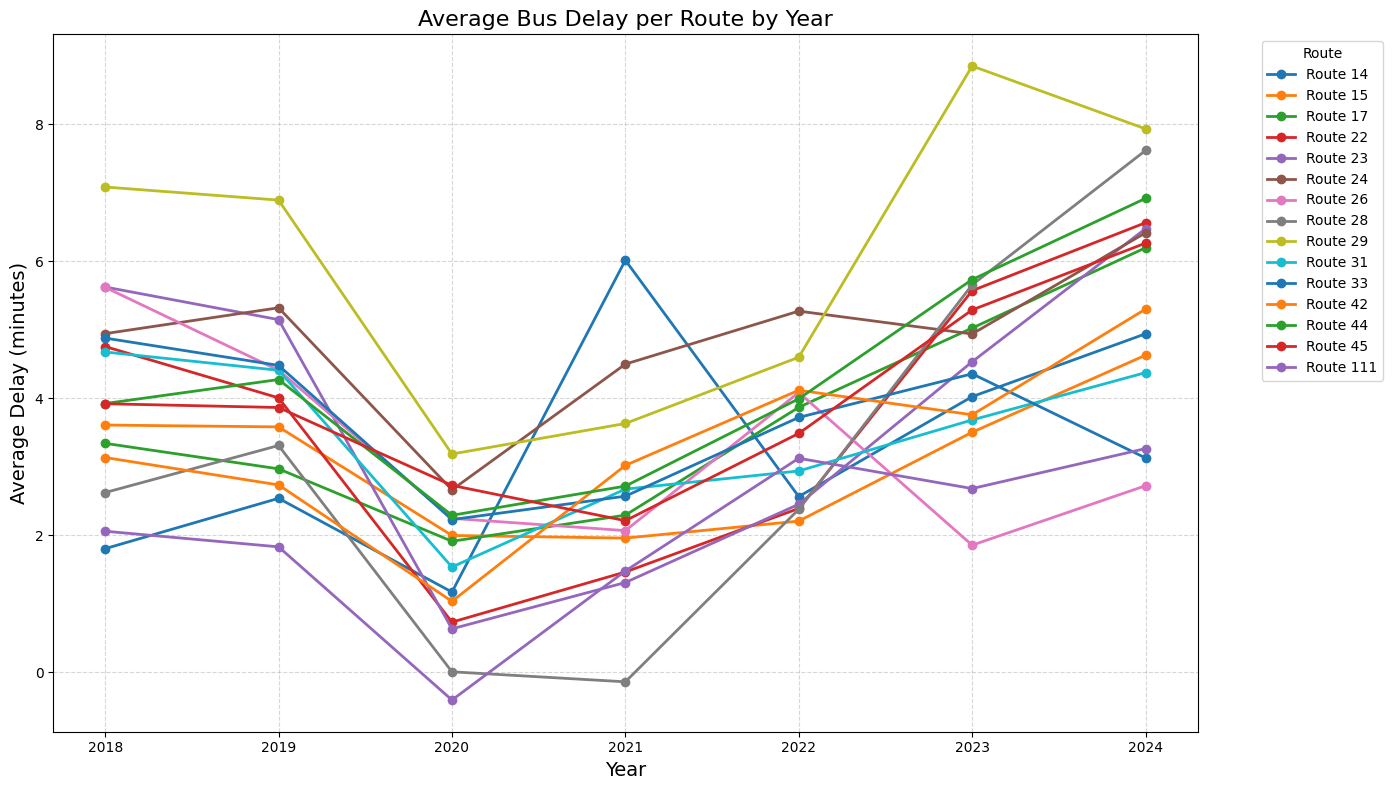

In [ ]:
plt.figure(figsize=(14, 8))

for route in sorted(avg_delay_all_clean['route_id'].unique(), key=lambda x: int(x)):
    route_data = avg_delay_all_clean[avg_delay_all_clean['route_id'] == route]
    plt.plot(route_data['year'], route_data['delay_min'], marker='o', linewidth=2, label=f'Route {route}')

plt.title('Average Bus Delay per Route by Year', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Average Delay (minutes)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='Route', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


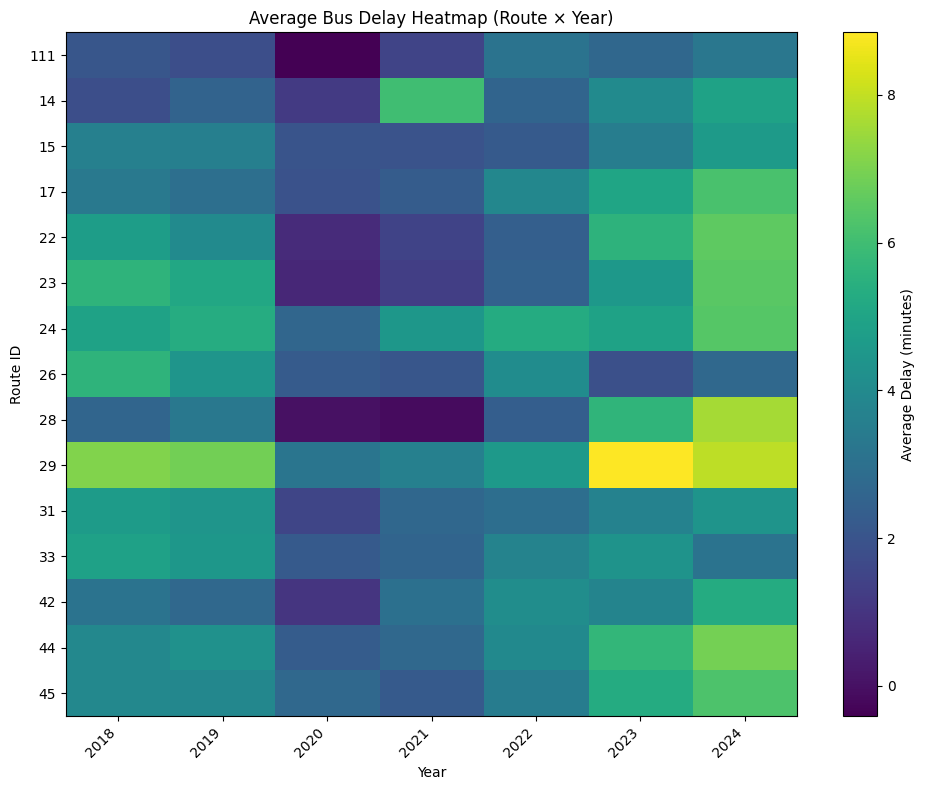

In [ ]:
heatmap_data = avg_delay_all_clean.pivot(
    index='route_id',
    columns='year',
    values='delay_min'
)

# Sort routes and years for a nice layout
heatmap_data = heatmap_data.sort_index()          # sort by route_id
heatmap_data = heatmap_data[sorted(heatmap_data.columns)]  # sort columns (years)

plt.figure(figsize=(10, 8))

# Plot heatmap
plt.imshow(heatmap_data, aspect='auto')
plt.colorbar(label='Average Delay (minutes)')

# Tick labels
plt.xticks(
    ticks=np.arange(len(heatmap_data.columns)),
    labels=heatmap_data.columns,
    rotation=45,
    ha='right'
)
plt.yticks(
    ticks=np.arange(len(heatmap_data.index)),
    labels=heatmap_data.index
)

plt.title('Average Bus Delay Heatmap (Route × Year)')
plt.xlabel('Year')
plt.ylabel('Route ID')

plt.tight_layout()
plt.show()

***End-to-End Travel Time per Route***

This section examines the end-to-end travel time for each target MBTA route, calculated from the first recorded timepoint of a trip to the final timepoint. While delay and wait time measure reliability from the passenger’s perspective, end-to-end travel time provides insight into the operational and physical characteristics of each route.

Analyzing end-to-end travel time helps contextualize delay patterns:

- Routes with inherently long travel times may be more susceptible to cumulative delays.

- Shorter routes with high delays suggest operational inefficiencies rather than scale.

- Comparing travel time across years allows detection of system-level changes, such as route realignments or infrastructure impacts.

Understanding travel time at the route level helps form a complete picture of on-road conditions and supports more informed predictive modeling.

In [ ]:
def extract_year(path):
    m = re.search(r"(20\d{2})", os.path.basename(path))
    return int(m.group(1)) if m else None

travel_records = []

for f in files:
    year = extract_year(f)
    df = pd.read_csv(f, dtype=str)

    # Need: route_id, half_trip_id, actual
    if not {'route_id', 'half_trip_id', 'actual'}.issubset(df.columns):
        continue

    df['actual_dt'] = pd.to_datetime(df['actual'], errors='coerce')
    df = df.dropna(subset=['actual_dt'])

    # Travel time per half-trip
    trip_tt = (
        df.groupby(['route_id', 'half_trip_id'])['actual_dt']
          .agg(lambda x: (x.max() - x.min()).total_seconds() / 60)
          .reset_index(name='travel_min')
    )
    trip_tt['year'] = year
    travel_records.append(trip_tt)

travel_times = pd.concat(travel_records, ignore_index=True)

# Average end-to-end travel time by route & year
avg_travel_by_route = (
    travel_times.groupby(['year','route_id'], as_index=False)['travel_min']
    .mean()
    .sort_values(['route_id','year'])
)

avg_travel_by_route.head()

,year,route_id,travel_min
0,2018,01,37.050997
178,2019,01,37.899015
355,2020,01,30.377619
524,2021,01,31.288920
684,2022,01,32.965482


In [ ]:
avg_travel_by_route_clean = avg_travel_by_route[avg_travel_by_route['year'] <= 2024]

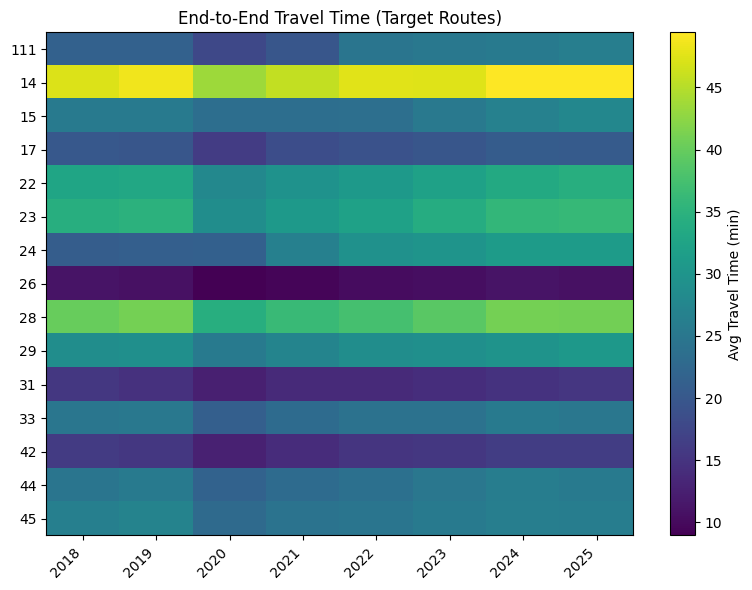

In [ ]:
target_routes = [
    '22','29','15','45','28','44','42','17',
    '23','31','26','111','24','33','14'
]

avg_travel_target = avg_travel_by_route[
    avg_travel_by_route['route_id'].isin(target_routes)
]

tt_target = avg_travel_target.pivot(
    index='route_id',
    columns='year',
    values='travel_min'
).sort_index()

plt.figure(figsize=(8, 6))
plt.imshow(tt_target, aspect='auto')
plt.colorbar(label='Avg Travel Time (min)')

plt.xticks(
    ticks=np.arange(len(tt_target.columns)),
    labels=tt_target.columns,
    rotation=45,
    ha='right'
)
plt.yticks(
    ticks=np.arange(len(tt_target.index)),
    labels=tt_target.index
)

plt.title('End-to-End Travel Time (Target Routes)')
plt.tight_layout()
plt.show()


In [ ]:
target_routes = [
    '22','29','15','45','28','44','42','17',
    '23','31','26','111','24','33','14'
]

tt = avg_travel_by_route[avg_travel_by_route['route_id'].isin(target_routes)] \
        .pivot(index='route_id', columns='year', values='travel_min')

***Heatmap of End-to-End Travel Time per Route (2018–2024)***

This clustered heatmap shows the average end-to-end travel time (in minutes) for each target route across years. Brighter colors indicate longer trips, while darker colors indicate shorter ones. The clustering groups routes with similar travel-time patterns, making it easier to compare how routes differ operationally and how their travel times change over time.

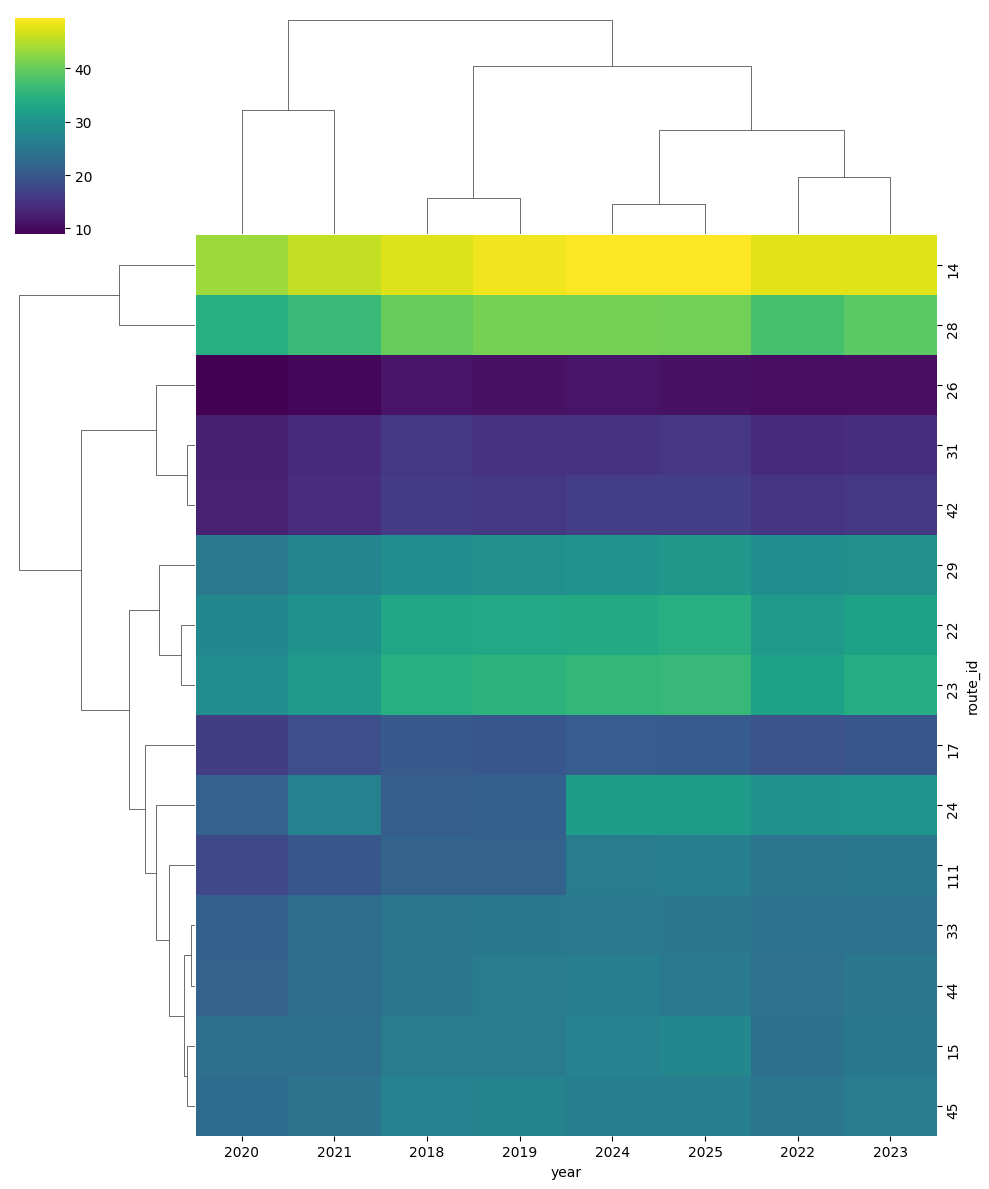

In [ ]:
sns.clustermap(tt, cmap='viridis', figsize=(10, 12))

***Feature Engineering: Cleaning Headways, Calculating Wait Time, and Labeling Status***

This step performs additional event-level feature engineering needed for wait-time analysis and delay classification.

- Cleans scheduled headway by converting it to numeric, removing invalid values, and keeping only reasonable headways.

- Computes rider wait time as half the scheduled headway (wait_min = sched_hw_min / 2).

- Calculates delay using scheduled vs. actual timestamps and removes rows with invalid or missing values.

- Assigns a status label:
```Delayed if delay_min > 1``` ```On-time otherwise```

- Stores the processed data with route, headway, delay, status, and year for later EDA and modeling.

This produces a clean, consistent dataset (```wait_df```) that will be used for analyzing wait times and building predictive models.

In [ ]:
wait_records = []

for f in files:
    year = extract_year_from_filename(f)
    if year is None:
        continue

    df = pd.read_csv(f, dtype=str)

    # must have these columns
    needed = {'route_id', 'scheduled_headway', 'scheduled', 'actual'}
    if not needed.issubset(df.columns):
        continue

    # HEADWAY CLEANING ------------------------------------------------------
    df['scheduled_headway'] = pd.to_numeric(df['scheduled_headway'], errors='coerce')

    # Remove bad headways: zero, negative, or unrealistically huge (> 3600 sec = 60 min)
    df.loc[df['scheduled_headway'] <= 0, 'scheduled_headway'] = np.nan
    df.loc[df['scheduled_headway'] > 3600, 'scheduled_headway'] = np.nan

    df = df.dropna(subset=['scheduled_headway'])
    if df.empty:
        continue

    # Convert to minutes
    df['sched_hw_min'] = df['scheduled_headway'] / 60.0
    df['wait_min'] = df['sched_hw_min'] / 2.0

    # DELAY + STATUS --------------------------------------------------------
    df['scheduled_dt'] = pd.to_datetime(df['scheduled'], errors='coerce')
    df['actual_dt'] = pd.to_datetime(df['actual'], errors='coerce')
    df['delay_min'] = (df['actual_dt'] - df['scheduled_dt']).dt.total_seconds() / 60.0

    df = df.dropna(subset=['delay_min'])
    if df.empty:
        continue

    df['status'] = np.where(df['delay_min'] > 1, 'Delayed', 'On-time')

    # Keep full detail for inspection
    wait_records.append(
        df[['route_id', 'scheduled_headway', 'sched_hw_min', 'wait_min', 'delay_min', 'status']].assign(year=year)
    )

wait_df = pd.concat(wait_records, ignore_index=True)

print(wait_df.head())
print(wait_df.columns)

  route_id  scheduled_headway  sched_hw_min  wait_min  delay_min   status  \
0       10             2400.0          40.0      20.0 -17.266667  On-time   
1      230             3180.0          53.0      26.5  11.016667  Delayed   
2      230             3180.0          53.0      26.5  -1.166667  On-time   
3      238             2520.0          42.0      21.0   1.700000  Delayed   
4       42             1800.0          30.0      15.0   4.133333  Delayed   

   year  
0  2025  
1  2025  
2  2025  
3  2025  
4  2025  
Index(['route_id', 'scheduled_headway', 'sched_hw_min', 'wait_min',
       'delay_min', 'status', 'year'],
      dtype='object')


In [ ]:
avg_wait_by_status = (
    wait_df
    .groupby(['year','status'], as_index=False)['wait_min']
    .mean()
    .sort_values(['year','status'])
)

print(avg_wait_by_status)

    year   status   wait_min
0   2018  Delayed   5.875503
1   2018  On-time   5.759821
2   2019  Delayed   5.894070
3   2019  On-time   5.704138
4   2020  Delayed   6.055701
5   2020  On-time   5.846881
6   2021  Delayed   5.669517
7   2021  On-time   5.635293
8   2022  Delayed   5.942726
9   2022  On-time   5.947831
10  2023  Delayed   6.280215
11  2023  On-time   6.044602
12  2024  Delayed   6.300326
13  2024  On-time   5.981094
14  2025  Delayed  16.892750
15  2025  On-time  17.011414


In [ ]:
avg_wait_by_status_clean = avg_wait_by_status[avg_wait_by_status['year'] <= 2024]

***Average Passenger Wait Time: On-Time vs Delayed Buses***

This plot compares average passenger wait times for buses classified as on-time (delay ≤ 1 minute) and delayed (delay > 1 minute). Since delayed buses create larger gaps between arrivals, they typically lead to longer expected wait times for riders. This visualization highlights how service reliability directly affects passenger experience.

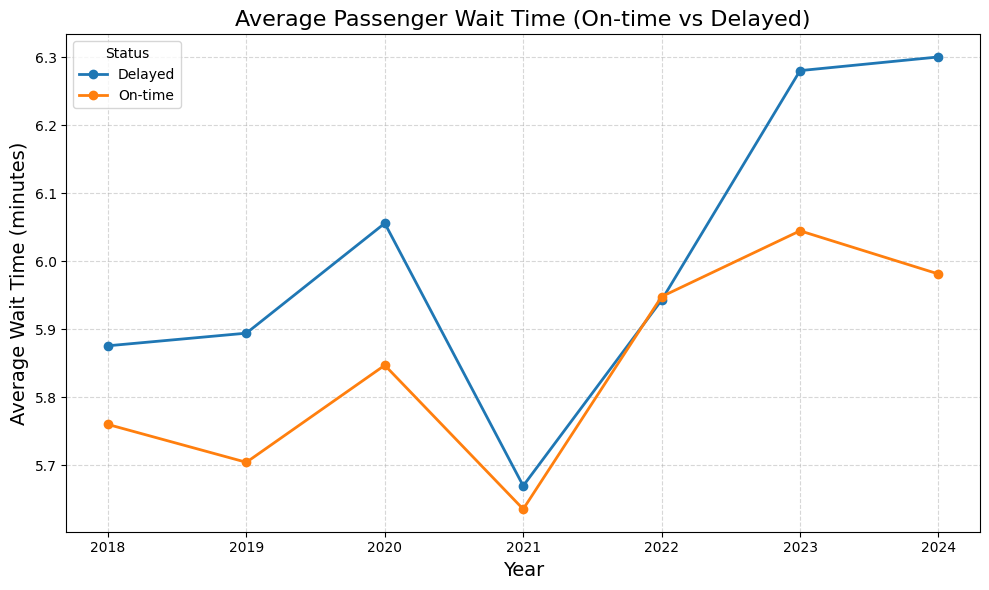

In [ ]:
wait_pivot = avg_wait_by_status_clean.pivot(
    index='year',
    columns='status',
    values='wait_min'
).sort_index()

plt.figure(figsize=(10, 6))

for status in wait_pivot.columns:
    plt.plot(wait_pivot.index, wait_pivot[status], marker='o', linewidth=2, label=status)

plt.title('Average Passenger Wait Time (On-time vs Delayed)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Average Wait Time (minutes)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='Status')
plt.tight_layout()
plt.show()

In [ ]:
wait_df[wait_df['year'] == 2025]['scheduled_headway'].describe()

,scheduled_headway
count,8.431473e+06
mean,2.031398e+03
std,7.724649e+02
min,6.000000e+01
25%,1.500000e+03
50%,1.800000e+03
75%,2.520000e+03
max,3.600000e+03


In [ ]:
wait_df[wait_df['year'] == 2025]['scheduled_headway'].head(50)

***2024 vs 2025 Scheduled Headways***

These histograms compare the distribution of scheduled headways in 2024 versus 2025. The 2025 data shows irregular or incomplete headway patterns because the year’s dataset is not yet finished, leading to missing months, uneven service records, and unrealistic headway values. For this reason, 2025 is excluded from all feature engineering and modeling to avoid biased or misleading results.

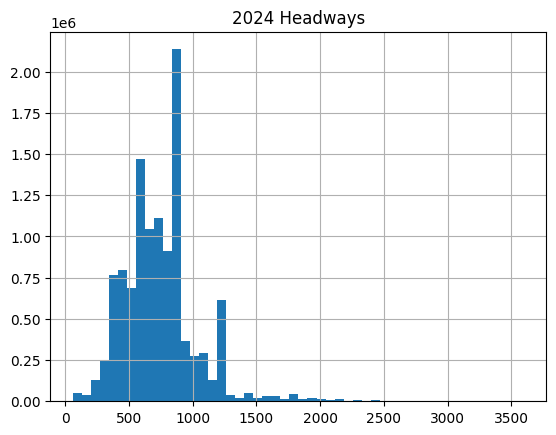

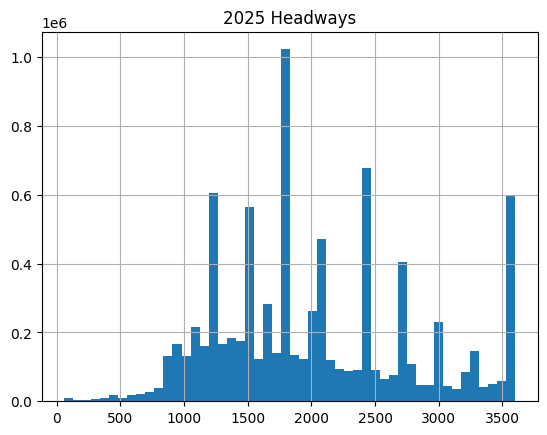

In [ ]:
wait_df[wait_df['year'] == 2024]['scheduled_headway'].hist(bins=50)
plt.title("2024 Headways")
plt.show()

wait_df[wait_df['year'] == 2025]['scheduled_headway'].hist(bins=50)
plt.title("2025 Headways")
plt.show()

In [ ]:
wait_df[wait_df['year'] == 2025]['sched_hw_min'].describe()

,sched_hw_min
count,8.431473e+06
mean,3.385663e+01
std,1.287442e+01
min,1.000000e+00
25%,2.500000e+01
50%,3.000000e+01
75%,4.200000e+01
max,6.000000e+01


In [ ]:
df_2025 = wait_df[wait_df['year'] == 2025]

print("Scheduled headway stats for 2025:")
print(df_2025['sched_hw_min'].describe())

print("\nRaw scheduled_headway values:")
print(wait_df[wait_df['year'] == 2025]['scheduled_headway'].head(20))


Scheduled headway stats for 2025:
count    8.431473e+06
mean     3.385663e+01
std      1.287442e+01
min      1.000000e+00
25%      2.500000e+01
50%      3.000000e+01
75%      4.200000e+01
max      6.000000e+01
Name: sched_hw_min, dtype: float64

Raw scheduled_headway values:
0     2400.0
1     3180.0
2     3180.0
3     2520.0
4     1800.0
5     1800.0
6     2700.0
7     2700.0
8     3000.0
9     1680.0
10    3060.0
11    3600.0
12    1800.0
13    1800.0
14    1800.0
15    1920.0
16    1920.0
17    1920.0
18    1920.0
19    1920.0
Name: scheduled_headway, dtype: float64


In [ ]:
city_delay_by_year = (
    avg_delay_all_clean
    .groupby('year', as_index=False)['delay_min']
    .mean()
    .rename(columns={'delay_min': 'avg_city_delay'})
)

city_delay_by_year


,year,avg_city_delay
0,2018,4.131052
1,2019,3.982723
2,2020,1.596282
3,2021,2.516599
4,2022,3.411318
5,2023,4.628466
6,2024,5.514014


In [ ]:
city_delay_by_year_clean = city_delay_by_year[city_delay_by_year['year'] <= 2024]

In [ ]:
avg_delay_target = (
    avg_delay_all_clean[ avg_delay_all_clean['route_id'].isin(target_routes) ]
    .groupby('year', as_index=False)['delay_min']
    .mean()
    .rename(columns={'delay_min': 'avg_target_delay'})
)

avg_delay_target


,year,avg_target_delay
0,2018,4.131052
1,2019,3.982723
2,2020,1.596282
3,2021,2.516599
4,2022,3.411318
5,2023,4.628466
6,2024,5.514014


In [ ]:
avg_delay_target_clean = avg_delay_target[avg_delay_target['year'] <= 2024]

***Feature Engineering and Balanced Sampling for Modeling***

This step prepares the final event-level dataset used for training the delay prediction model. For each file, the code:

- Parses scheduled and actual timestamps and computes delay in minutes.

- Assigns a binary label: delayed (>1 min) vs. on-time.

- Cleans and converts headway fields into numeric form.

- Creates additional temporal and operational features, including hour of day, weekday, peak-hour indicator, weekend indicator, AM/PM flag, headway ratio, and a delay flag.

- Performs 20% stratified sampling per route and per label to reduce data size while keeping class balance and ensuring all routes remain represented.

All sampled subsets are combined into a single modeling dataset (```model_df```), which is used for training and evaluating the machine learning models.

In [ ]:
model_records = []
sample_frac = 0.20  # 20% per route

for f in files:
    year = extract_year_from_filename(f)
    if year is None:
        continue

    try:
        df = pd.read_csv(f, dtype=str)
    except:
        continue

    needed = {'route_id','scheduled','actual','scheduled_headway','headway','direction','stop_id'}
    if not needed.issubset(df.columns):
        continue

    # --- time parsing ---
    df['scheduled_dt'] = pd.to_datetime(df['scheduled'], errors='coerce')
    df['actual_dt'] = pd.to_datetime(df['actual'], errors='coerce')
    df['delay_min'] = (df['actual_dt'] - df['scheduled_dt']).dt.total_seconds() / 60

    df = df.dropna(subset=['delay_min'])
    if df.empty:
        continue

    # --- label ---
    df['label'] = (df['delay_min'] > 1).astype(int)

    # --- numeric headways ---
    df['scheduled_headway'] = pd.to_numeric(df['scheduled_headway'], errors='coerce')
    df['headway'] = pd.to_numeric(df['headway'], errors='coerce')
    df = df.dropna(subset=['scheduled_headway','headway'])
    if df.empty:
        continue

    # --- extra temporal features ---
    df['year'] = year
    df['hour'] = df['scheduled_dt'].dt.hour
    df['weekday'] = df['scheduled_dt'].dt.weekday

    # --- ADD NEW FEATURES HERE ---
    # peak hour (commute periods)
    df["is_peak"] = df["hour"].isin([6,7,8,16,17,18]).astype(int)

    # weekend indicator
    df["is_weekend"] = (df["weekday"] >= 5).astype(int)

    # AM vs PM
    df["is_am"] = (df["hour"] < 12).astype(int)

    # headway ratio (actual vs scheduled)
    df["headway_ratio"] = df["headway"] / df["scheduled_headway"]

    # binary: was the bus already delayed when its trip segment started?
    df["delay_flag"] = (df["delay_min"] > 0).astype(int)

    # --- sample per route ---
sampled = []

for route, df_route in df.groupby('route_id'):
    dfs = []
    for label, df_label in df_route.groupby('label'):
        n = max(1, int(len(df_label) * sample_frac))
        n = min(n, len(df_label))  # cannot sample more than exists
        dfs.append(df_label.sample(n=n, random_state=42))
    df_sample = pd.concat(dfs)
    sampled.append(df_sample)

df_balanced = pd.concat(sampled, ignore_index=True)

model_records.append(df_balanced)

model_df = pd.concat(model_records, ignore_index=True)

print("Final sampled model_df:", model_df.shape)
print("Unique routes represented:", model_df['route_id'].nunique())


Final sampled model_df: (185307, 25)
Unique routes represented: 78


***Train–Test Split for Classification and Regression***

This step prepares the data for modeling by separating features and targets, then splitting them into training and testing sets.

- ```X``` contains the engineered features used for prediction.

- ```y_class``` is the binary label (on-time vs delayed) for classification.

- ```y_reg``` is the continuous delay value for regression.

An 80/20 train–test split is applied to ensure that model performance is evaluated on unseen data, using a fixed random seed for reproducibility.

In [ ]:
from sklearn.model_selection import train_test_split

X = model_df[['route_id','direction','hour','weekday',
              'scheduled_headway','headway',
              'is_peak','is_weekend','is_am',
              'headway_ratio','delay_flag']]
y_class = model_df['label']
y_reg = model_df['delay_min']

X_train, X_test, y_train_c, y_test_c = train_test_split(X, y_class, test_size=0.2, random_state=42)
_, _, y_train_r, y_test_r = train_test_split(X, y_reg, test_size=0.2, random_state=42)

***Preprocessing: One-Hot Encoding Categorical Features***

This step defines the preprocessing pipeline for the model.

- Categorical features (```route_id```, ```direction```) are transformed using one-hot encoding, allowing the model to learn from non-numeric route and direction identifiers.

- Numeric features are passed through unchanged.

The resulting ```ColumnTransformer``` (```preprocess```) ensures all features are in a model-ready format.

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

categorical = ['route_id', 'direction']
numeric = ['hour', 'weekday', 'scheduled_headway', 'headway']

preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical),
        ('num', 'passthrough', numeric)
    ]
)

In [ ]:
!zip -r MBTA_standardized.zip MBTA_avg_delay_standardized
!cp MBTA_standardized.zip ../../data/average_delay/


In [ ]:
df_sample.to_csv("training_sample.csv", index=False)
!cp training_sample.csv ../../data/average_delay/

In [ ]:
model_df.to_csv("mbta_features.csv", index=False)
!cp mbta_features.csv ../../data/average_delay/

***Classification Model: Random Forest Pipeline***

This block builds and trains a classification model to predict whether a bus will be on-time or delayed. A pipeline is used to combine preprocessing with modeling:

- The preprocessing step one-hot encodes categorical variables and passes numeric features through.

- The Random Forest classifier (300 trees, class-weighted) learns patterns associated with delay.

The model is then fit on the training data (```X_train```, ```y_train_c```).

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

clf_model = Pipeline([
    ('prep', preprocess),
    ('rf', RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        class_weight='balanced'
    ))
])

clf_model.fit(X_train, y_train_c)


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['route_id', 'direction']),
                                                 ('num', 'passthrough',
                                                  ['hour', 'weekday',
                                                   'scheduled_headway',
                                                   'headway'])])),
                ('rf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=300, random_state=42))])

***Classification Results and Confusion Matrix – Random Forest***

This section evaluates the classification model that predicts whether a bus will be delayed (>1 minute) or on-time. The model achieves 72% accuracy, with stronger performance on the delayed class (higher precision and recall). The confusion matrix visualizes how predictions compare to true labels: most delayed buses are correctly identified, though some overlap exists where on-time and delayed events are misclassified. Overall, the model demonstrates solid performance in distinguishing delay status using the engineered features.

=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

           0       0.67      0.65      0.66     15453
           1       0.75      0.77      0.76     21609

    accuracy                           0.72     37062
   macro avg       0.71      0.71      0.71     37062
weighted avg       0.72      0.72      0.72     37062

Confusion matrix:
 [[10044  5409]
 [ 4991 16618]]


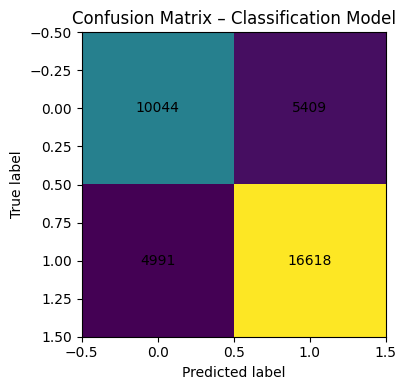

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

# predictions
y_pred_c = clf_model.predict(X_test)

print("=== CLASSIFICATION REPORT ===")
print(classification_report(y_test_c, y_pred_c))

cm = confusion_matrix(y_test_c, y_pred_c)
print("Confusion matrix:\n", cm)

# confusion matrix plot
plt.figure(figsize=(5, 4))
plt.imshow(cm)
plt.title("Confusion Matrix – Classification Model")
plt.xlabel("Predicted label")
plt.ylabel("True label")

# add counts in each cell
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.tight_layout()
plt.show()


***Regression Model Performance (Predicting Delay Minutes)***

The regression model yields an MAE of ~3.02 minutes, meaning that on average, predictions are about three minutes away from the actual delay value. The R² score of 0.29 indicates the model explains roughly 29% of the variance in bus delays—a reasonable result given that real-world delays are influenced by many unpredictable factors (traffic, weather, incidents).

In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score

y_pred_r = reg_model.predict(X_test)

print("MAE:", mean_absolute_error(y_test_r, y_pred_r))
print("R²:", r2_score(y_test_r, y_pred_r))


MAE: 3.0165336381416457
R²: 0.29249995881405466


***Gradient Boosting Regression Performance***

The Gradient Boosting Regressor improves delay prediction performance compared to the earlier model, achieving an MAE of ~2.95 minutes and an R² of ~0.34.

- The slightly lower MAE indicates the model predicts delay values more accurately on average.

- The higher R² means the model now explains about 34% of the variance in bus delays—an improvement over the previous ~29%.

This suggests that Gradient Boosting captures nonlinear relationships and interactions between features more effectively, making it a better choice for predicting continuous delay values.

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

reg_model = Pipeline([
    ('prep', preprocess),
    ('gb', GradientBoostingRegressor(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=4,
        random_state=42
    ))
])

reg_model.fit(X_train, y_train_r)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['route_id', 'direction']),
                                                 ('num', 'passthrough',
                                                  ['hour', 'weekday',
                                                   'scheduled_headway',
                                                   'headway'])])),
                ('gb',
                 GradientBoostingRegressor(learning_rate=0.05, max_depth=4,
                                           n_estimators=400,
                                           random_state=42))])

In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score

y_pred_r = reg_model.predict(X_test)

print("\n=== REGRESSION REPORT (New Features) ===")
print("MAE:", mean_absolute_error(y_test_r, y_pred_r))
print("R²:", r2_score(y_test_r, y_pred_r))


=== REGRESSION REPORT (New Features) ===
MAE: 2.951113904149969
R²: 0.34144097059564005


***XGBoost Regression Performance***

XGBoost provides the strongest regression performance so far, achieving an MAE of ~2.85 minutes and an R² of ~0.36.

- The lower MAE indicates improved accuracy in predicting the actual delay in minutes.

- The higher R² suggests XGBoost explains about 36% of the variance in bus delays, outperforming both Random Forest and Gradient Boosting.

This improvement reflects XGBoost’s ability to model complex nonlinear patterns and interactions across the engineered features, making it the most effective regressor tested for continuous delay prediction.

In [ ]:
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score

reg_model = Pipeline([
    ('prep', preprocess),
    ('xgb', XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='reg:squarederror',
        n_jobs=-1,
        random_state=42
    ))
])

reg_model.fit(X_train, y_train_r)

y_pred_r = reg_model.predict(X_test)

print("\n=== REGRESSION REPORT (XGBoost + New Features) ===")
print("MAE:", mean_absolute_error(y_test_r, y_pred_r))
print("R²:", r2_score(y_test_r, y_pred_r))


=== REGRESSION REPORT (XGBoost + New Features) ===
MAE: 2.8534696927696306
R²: 0.35823928302879693


***Residual Plot – XGBoost Regression***

This residual plot shows the difference between actual and predicted delays across the range of predicted values. The residuals are randomly scattered around zero with no clear pattern, indicating that the XGBoost model is not systematically over- or under-predicting and is capturing the underlying relationships in the data reasonably well.

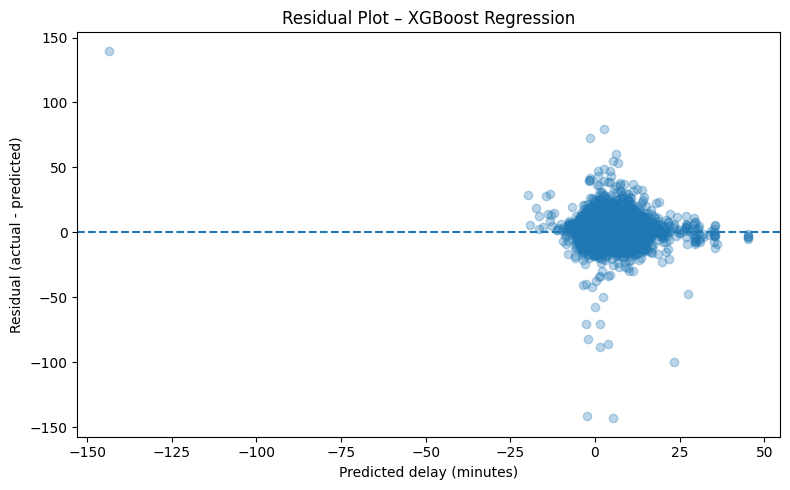

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

residuals = y_test_r - y_pred_r

plt.figure(figsize=(8, 5))
plt.scatter(y_pred_r, residuals, alpha=0.3)
plt.axhline(0, linestyle='--')
plt.xlabel("Predicted delay (minutes)")
plt.ylabel("Residual (actual - predicted)")
plt.title("Residual Plot – XGBoost Regression")
plt.tight_layout()
plt.show()


***Predicted vs Actual Delay – XGBoost Regression***

This plot compares the model’s predicted delay values to the actual delays from the test set. The dashed diagonal line represents perfect prediction. Points close to this line indicate accurate predictions, while points farther away represent larger errors. The overall spread around the line shows that XGBoost captures general delay patterns but still exhibits natural variability due to the unpredictable nature of bus operations.

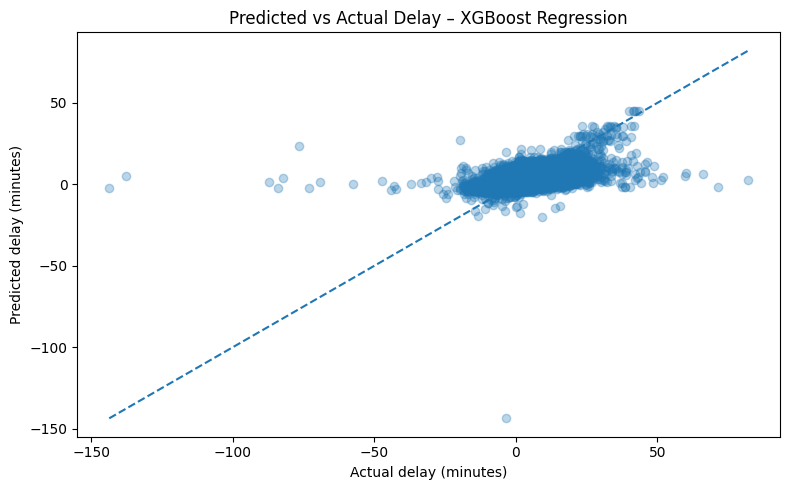

In [ ]:
plt.figure(figsize=(8, 5))
plt.scatter(y_test_r, y_pred_r, alpha=0.3)

min_delay = min(y_test_r.min(), y_pred_r.min())
max_delay = max(y_test_r.max(), y_pred_r.max())
plt.plot([min_delay, max_delay], [min_delay, max_delay], linestyle='--')

plt.xlabel("Actual delay (minutes)")
plt.ylabel("Predicted delay (minutes)")
plt.title("Predicted vs Actual Delay – XGBoost Regression")
plt.tight_layout()
plt.show()
